In [2]:
import numpy as np
import os
from os.path import join as pjoin

from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

import tensorflow as tf
from keras import backend as K

In [3]:
from dataloader import section_loader, F3_generator
from models import UNet
from metrics import mIoU
from utils import make_aug, PlotHistory

In [4]:
lossf = 'categorical_crossentropy'

bs = 1
_epochs = 5
verbose_train = 2
type_aug = "aug1" #no_aug
f1 = 16

### Load Data

In [4]:
train_loader_i = section_loader(direct = 'i', split = 'train')
train_loader_x = section_loader(direct = 'x', split = 'train')
val_loader_i = section_loader(direct = 'i',split = 'val')
val_loader_x = section_loader(direct = 'x',split = 'val')

dat_tr1 = tf.data.Dataset.from_generator(train_loader_i.generator, output_types = (tf.float64, tf.float32), 
                                         output_shapes = ((688,256,1), (688,256,6)))
dat_tr2 = tf.data.Dataset.from_generator(train_loader_x.generator, output_types = (tf.float64, tf.float32),
                                        output_shapes = ((400,256,1), (400,256,6)))

dat_vl1 = tf.data.Dataset.from_generator(val_loader_i.generator, output_types = (tf.float64, tf.float32),
                                        output_shapes = ((688,256,1), (688,256,6)))
dat_vl2 = tf.data.Dataset.from_generator(val_loader_x.generator, output_types = (tf.float64, tf.float32),
                                        output_shapes = ((400,256,1), (400,256,6)))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


### Data Augmentation

In [5]:
data_tr = [make_aug(dat_tr1, type_aug), make_aug(dat_tr2, type_aug)]
data_vl = [dat_vl1, dat_vl2]

num_train = len(train_loader_i) + len(train_loader_x)
num_val = len(val_loader_i) + len(val_loader_x)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
train_gen = F3_generator(data_tr, bs)
val_gen = F3_generator(data_vl, bs)

### Modeling

In [5]:
model = UNet(n_classes=6, filters=f1, n_block=4, BN=True, DP=False)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
_____________________________________

In [8]:
lr = 1e-3

# opt = RMSprop(lr=lr)  
opt = Adam(lr=lr, amsgrad=False)

model.compile(optimizer=opt,
              loss = lossf,
              metrics=['acc', mIoU])

### Training

In [6]:
filepath = 'Unet_' + str(f1) + '_' + type_aug + '_bn2.h5'
stopPatience = 10

In [9]:
modelCheck = ModelCheckpoint(filepath,verbose=1, save_best_only=True, save_weights_only=True, period=1) # monitor="val_dice_loss", mode = 'min')
earlystopper = EarlyStopping(patience=stopPatience, verbose=1) # monitor="val_dice_loss", mode = 'min')
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=stopPatience//2, min_lr=0.0000005, verbose=1) # monitor="val_dice_loss", mode = 'min')
cb = [earlystopper,reduce_lr,modelCheck]

In [10]:


hs = model.fit_generator(train_gen,epochs=_epochs,
                    steps_per_epoch=num_train//bs,
                    callbacks=cb,
                    validation_data=val_gen, validation_steps=num_val//bs,
                    verbose = verbose_train, workers = 0)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
 - 33s - loss: 0.3232 - acc: 0.9130 - mIoU: 0.6301 - val_loss: 0.1188 - val_acc: 0.9615 - val_mIoU: 0.7481

Epoch 00001: val_loss improved from inf to 0.11881, saving model to Unet_16_aug1_bn2.h5
Epoch 2/5
 - 26s - loss: 0.0811 - acc: 0.9721 - mIoU: 0.7854 - val_loss: 0.1571 - val_acc: 0.9473 - val_mIoU: 0.7384

Epoch 00002: val_loss did not improve from 0.11881
Epoch 3/5
 - 26s - loss: 0.0560 - acc: 0.9785 - mIoU: 0.8452 - val_loss: 0.0650 - val_acc: 0.9768 - val_mIoU: 0.8388

Epoch 00003: val_loss improved from 0.11881 to 0.06502, saving model to Unet_16_aug1_bn2.h5
Epoch 4/5
 - 26s - loss: 0.0565 - acc: 0.9782 - mIoU: 0.8497 - val_loss: 0.0666 - val_acc: 0.9767 - val_mIoU: 0.8749

Epoch 00004: val_loss did not improve from 0.06502
Epoch 5/5
 - 26s - loss: 0.0590 - acc: 0.9775 - mIoU: 0.8523 - val_loss: 0.0445 - val_acc: 0.9830 - val_mIoU: 0.9082

Ep

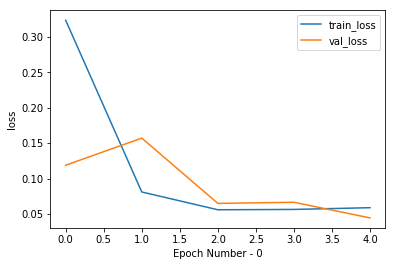

In [11]:
PlotHistory(hs, 'loss')

### Testing

In [7]:
from dataloader import section_loader_test
from utils import calculate_metrics_total

In [9]:
model.load_weights(filepath)

In [12]:
root = '/scratch/parceirosbr/maykol.trinidad/dataset/F3'
labels1  = np.load(pjoin(root,'test_once', 'test1_labels.npy' ))
labels2  = np.load(pjoin(root,'test_once', 'test2_labels.npy' ))

In [13]:
probs_predict1 = section_loader_test(model, 'test1', get_prob=True)
probs_predict2 = section_loader_test(model, 'test2', get_prob=True)

labels_predict1 = np.argmax(probs_predict1, axis=-1)
labels_predict2 = np.argmax(probs_predict2, axis=-1)

In [14]:
calculate_metrics_total(labels1, labels_predict1, labels2, labels_predict2)

Accuracy 1:  0.8881
Accuracy 2:  0.935
Pixel Accuracy:  0.9097
Class Accuracy:  [0.705 0.552 0.809 0.968 0.914 0.98 ]
Mean Class Accuracy:  0.8213333333333335
FWIOU:  0.8442
mIoU:  0.7011939871980352
freq: [0.21476892 0.09928044 0.5072718  0.06050776 0.09562095 0.02255013]
